In [1]:
import numpy as np
import librosa

import matplotlib.pyplot as plt
import librosa.display
import scipy.signal
from scipy import signal
import os

os.getcwd()



'/home/yxuhuang/AudioMap/TrackSSL'

(217108,)
sample_rate:  44100


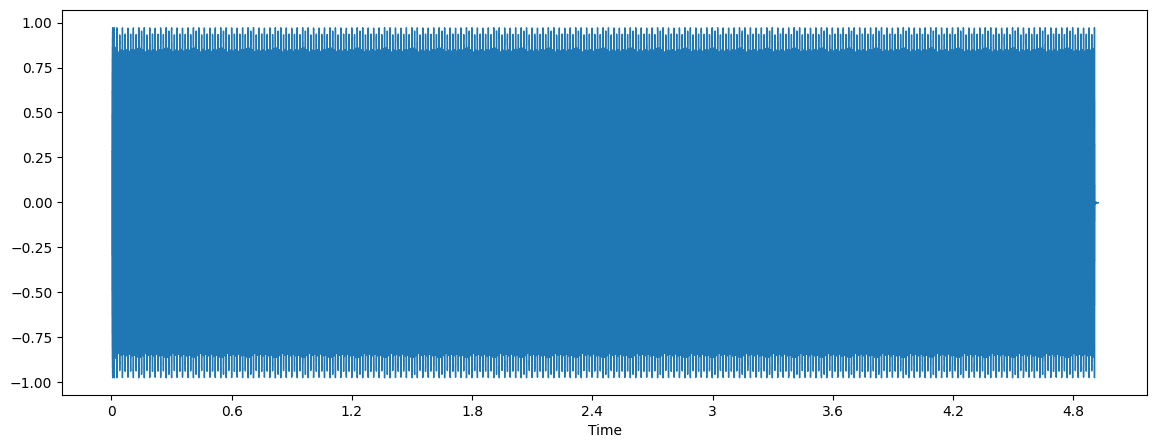

In [2]:
# Load the WAV file
filename = os.getcwd() + "/../scdata/London on da Track (Shows the Screen) Drumkit/808s/8ful.wav"
#filename = os.getcwd() + "/../scdata/Chief Keef (Shows the Screen) Drumkit/808s/808  Chief Keef Big Boss.wav"
#filename = os.path.join('data', 'your_audio_file.wav')
audio, sample_rate = librosa.load(filename, sr=None)
print(audio.shape)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sample_rate)
print('sample_rate: ', sample_rate)


### Converting to DB mel_spectrum

#### According to Nyquist-Shannon Sampling Theorem, to capture a frequency without aliasing you have to have double the sample rate, and human is capable of hearing 20kHz, thus the CD quality: 44.1kHz

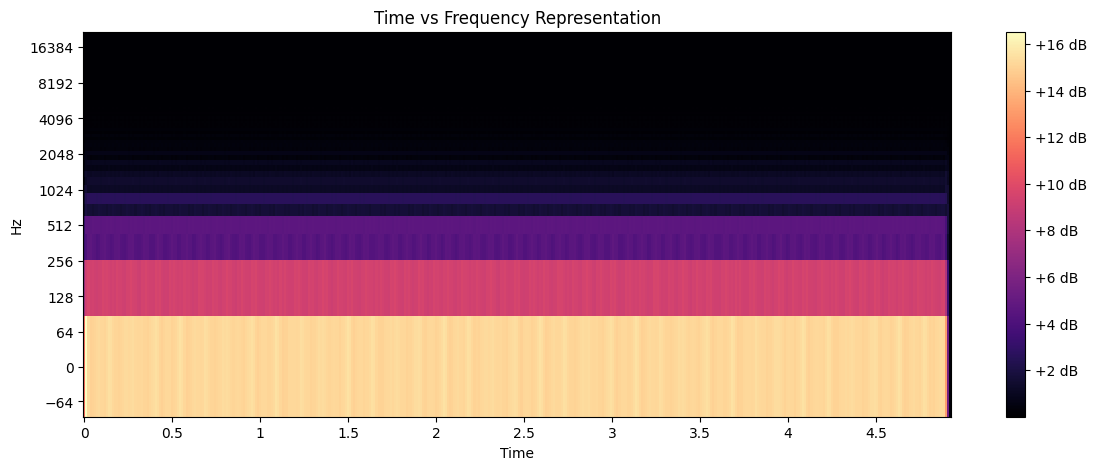

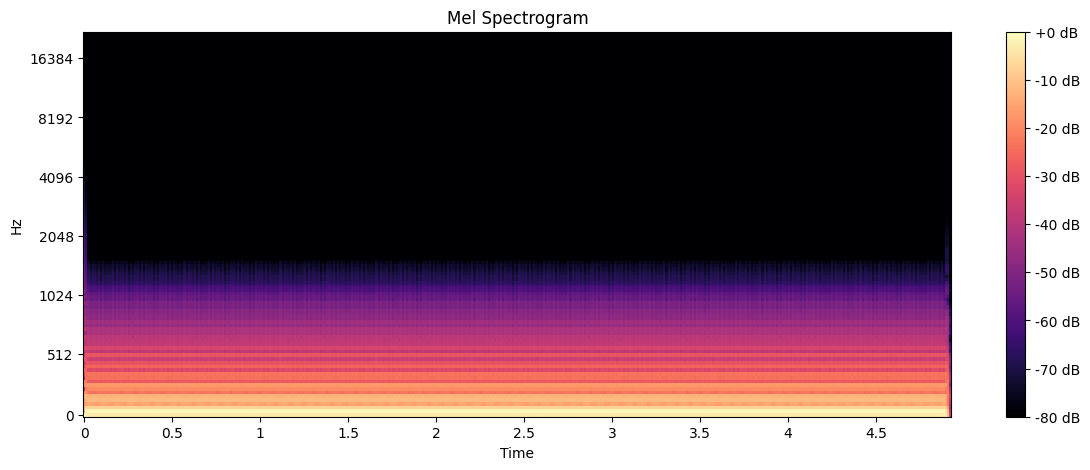

In [3]:
# Compute the Short-Time Fourier Transform (STFT) with Hanning window
n_fft = 2048
hop_length = 512
window = scipy.signal.windows.hann(n_fft)
#window = scipy.signal.hann(n_fft)
stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=window)
stft = np.abs(stft)


# Plot the time vs frequency representation
stft_spec, phase = librosa.magphase(stft)
stft_mel = librosa.feature.melspectrogram(S=stft_spec, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, window=window)
plt.figure(figsize=(14, 5))
librosa.display.specshow(stft_mel , sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Time vs Frequency Representation')
plt.show()

# Compute the Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=audio, sr=sample_rate, n_fft=n_fft, 
    hop_length=hop_length, window=window, 
    n_mels=128,power=1.0, center=True, pad_mode="reflect" , htk=True)
    #center=True,
    #pad_mode="reflect",
    #power=2.0,
    #n_mels=n_mels,
    #norm='slaney',
    #htk=True,
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max, top_db=80)

# Plot the Mel spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate,hop_length=hop_length  ,x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [4]:
import torch
import torchaudio as TA
import math, random
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    #print(audio_file.shape)
    sig, sr = TA.load(audio_file)
    return (sig, sr)
  @staticmethod
  def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])

      return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
      sig, sr = aud

      if (sr == newsr):
        # Nothing to do
        return aud

      num_channels = sig.shape[0]
      # Resample first channel
      resig = TA.transforms.Resample(sr, newsr)(sig[:1,:])
      if (num_channels > 1):
        # Resample the second channel and merge both channels
        retwo = TA.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])

      return ((resig, newsr))
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = TA.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = TA.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  #for ssl DA:
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
          aug_spec = TA.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
          aug_spec = TA.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

rechan shape: torch.Size([2, 217108])
dur_aud shape: torch.Size([2, 176000])
aug_sgram shape: torch.Size([2, 64, 344])
<class 'torch.Tensor'>


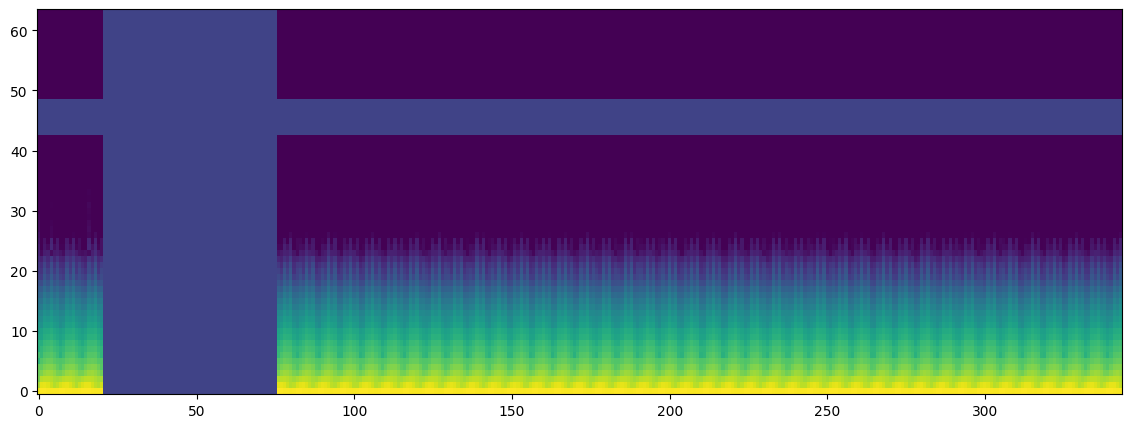

In [5]:
duration = 4000
sr = 44100
channel = 2
shift_pct = 0.4

#shifted_audio, sr = AudioUtil.time_shift((audio, sample_rate), 0.2)
audio = AudioUtil.open(filename)
reaud = AudioUtil.resample(audio, sr)
rechan = AudioUtil.rechannel(reaud, 2)
print("rechan shape:", rechan[0].shape)

dur_aud = AudioUtil.pad_trunc(rechan, duration)
print("dur_aud shape:", dur_aud[0].shape)
shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
sgram = AudioUtil.spectro_gram(shift_aud, n_fft=1024)
aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
print("aug_sgram shape:",aug_sgram.shape)
print(type(aug_sgram))
plt.figure(figsize=(14, 5))
plt.imshow(aug_sgram[0].numpy(), aspect="auto", origin="lower", cmap="viridis")
# librosa.display.specshow(aug_sgram[0].numpy(),  hop_length=hop_length, x_axis='time', y_axis='mel')

In [6]:
# 

### Gathering DataSource && data augment

In [7]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df):
    self.df = df
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # the relative path
    audio_file = self.df.loc[idx, "Full-Path"] 
    # Get the Class I
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram

In [8]:
import pandas as pd
import wave
def create_wav_data_store(base_folder):
    data = []  # List to store information about each WAV file

    # Walk through the directo ry structure
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.stat(file_path).st_size
            # if(file_size == 0):
            #     print(file_path)
            if file.startswith('.'):
                continue
            if file.lower().endswith('.wav') and file_size > 0:
                try: 
                    obj = wave.open(file_path, mode=None)
                    valid = True
                    obj.close() 
                    data.append({
                        'Full-Path': file_path
                    })
                except wave.Error:
                    print("Invalid file: ", file_path)
               

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    return df

### Data Augmentation on Mel

Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/Chop Rise.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/Chop FX (11).wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/KEEF FX 2.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/School Bell.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/KEEF FX 1.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/Dp FX.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/Chop FX (13).wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Screen) Drumkit/FX/KEEF FX 1 - Part_1.wav
Invalid file:  /home/yxuhuang/AudioMap/TrackSSL/../scdata/Chief Keef (Shows the Scr

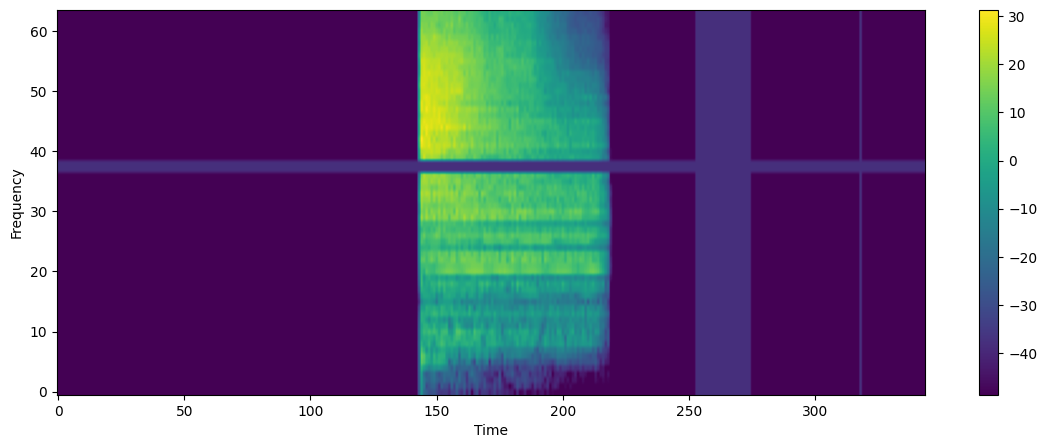

In [9]:
df = create_wav_data_store(os.getcwd() + "/../scdata/")
augmented_data = SoundDS(df)

plt.figure(figsize=(14, 5))
plt.imshow(augmented_data[0][0].numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
#plt.title(f"Augmented Spectrogram - Sample {index}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()


### Audio Processing


In [10]:
#https://lightning.ai/docs/pytorch/LTS/notebooks/course_UvA-DL/13-contrastive-learning.html
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "CheckPoints/")
NUMCPU = os.cpu_count()
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
#print(CHECKPOINT_PATH)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cuda:0


In [ ]:

class SimCLR(pl.LightningModule):
    def __init__(self, projection_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.temperture = temperature
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes= projection_dim
        )  # num_classes is the output size of the last linear layer

        #The representation h (before projection) is 2048-dimensional here
        #when a projection head is used, similar results are observed regardless of output dimension
        #Table3..... Both h and g(h) are of the same dimensionality 2048
        self.projection_head = nn.Sequential(
            nn.Linear(projection_dim, projection_dim),  # Linear projection
            nn.ReLU(inplace=True),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, self.hparams.max_epochs, 0
        )
        return [optimizer], [scheduler]
   

    def info_nce_loss(self, batch, mode="train"):
        
        imgs = batch
        #https://discuss.pytorch.org/t/convert-torchaudio-melspectograms-for-resnet-networks/163385
        imgs = imgs.view(-1, 1, 64, 344)  # Shape: [512, 1, 64, 344]
        #copied to 3 channels
        imgs = imgs.repeat(1, 3, 1, 1) # Shape: [512, 3, 64, 344]

        #print("into the convnet")
        # Encode all images
        encoded = self.convnet(imgs)
        # put into UMAP, flattened, 
        # print("encoded shape:",encoded.shape)
        proj = self.projection_head(encoded)
        #print("encoded shape:", proj.shape)
        # Calculate cosine similarity
        # feats[:, None, :]: [batch_size, 1, feature_dim] 
        # feats[None, :, :]: [1, batch_size, feature_dim]
        # Result of broadcasting: [batch_size, batch_size, feature_dim].
        cos_sim = F.cosine_similarity(proj[:, None, :], proj[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

        #does simclr always output a 1  * n dimension tensor for representation?


        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

    def load_from_checkpoint(self, checkpoint_path):
        self.load_state_dict(torch.load(checkpoint_path)["state_dict"])

In [12]:
from pytorch_lightning import loggers as pl_loggers
def train_simclr(batch_size, unlabeled_data, train_data,max_epochs=500 ,logger= pl_loggers.TensorBoardLogger('logs/'),**kwargs):
        trainer = pl.Trainer(
            default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
            accelerator="gpu" if str(device) == "cuda:0" else "cpu",
            devices=1 if str(device) == "cuda:0" else NUMCPU,
            max_epochs=max_epochs,
            callbacks=[
                ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
                LearningRateMonitor("epoch"),
            ],
            logger=logger
        )
        trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

        # Check whether pretrained model exists. If yes, load it and skip training
        pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model at {pretrained_filename}, loading...")
            # Automatically loads the model with the saved hyperparameters
            model = SimCLR.load_from_checkpoint(pretrained_filename)
        else:
            print(unlabeled_data[0].shape ,"vs", train_data[0].shape)
            train_loader = data.DataLoader(
                unlabeled_data,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                pin_memory=True,
                num_workers=NUMCPU,
            )
            val_loader = data.DataLoader(
                train_data,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                pin_memory=True,
                num_workers=NUMCPU,
            )
            pl.seed_everything(42)  # To be reproducable
            model = SimCLR(max_epochs=max_epochs, **kwargs)
            print("before fit")
            trainer.fit(model, train_loader, val_loader)
            # Load best checkpoint after training
            model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

        return model



In [13]:
from sklearn.model_selection import train_test_split
from pytorch_lightning import loggers as pl_loggers

from torch.utils.data import Subset

dataset_size = len(augmented_data)
indices = list(range(dataset_size))

# Split indices
train_indices, unlabeled_indices = train_test_split(indices, test_size=0.8, random_state=42)
print("indices:", train_indices, unlabeled_indices)

# Create subsets
train_dataset = Subset(augmented_data, train_indices)
unlabeled_dataset = Subset(augmented_data, unlabeled_indices)

print(f"Labeled data: {len(train_dataset)} samples")
print(f"Unlabeled data: {len(unlabeled_dataset)} samples")
torch.cuda.empty_cache()
print("Used memory:", torch.cuda.memory_allocated() / 1e9, "GB")
print("Cached memory:", torch.cuda.memory_reserved() / 1e9, "GB")
tb_logger = pl_loggers.TensorBoardLogger('logs/')

simclr_model = train_simclr(
    batch_size= 50,unlabeled_data= unlabeled_dataset, train_data=train_dataset, projection_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=100, logger=tb_logger
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42


indices: [6791, 7602, 5000, 5853, 1279, 7039, 7723, 1555, 7131, 3190, 4566, 4802, 7503, 4841, 3594, 6035, 1920, 513, 4177, 1308, 5667, 914, 3452, 3695, 4242, 3156, 2198, 774, 4425, 6150, 6097, 943, 822, 5005, 4277, 164, 5619, 4547, 3983, 2538, 7514, 1311, 5207, 7169, 5383, 6581, 7312, 3300, 3310, 327, 5886, 2490, 7415, 6103, 5954, 7711, 4408, 832, 3079, 3462, 5297, 6931, 54, 6230, 4064, 3451, 6305, 1901, 1481, 4873, 4895, 4150, 3335, 6016, 4926, 946, 5797, 3293, 2161, 7776, 5083, 6685, 3057, 5490, 768, 7410, 3495, 285, 7789, 4524, 7015, 2332, 2717, 2079, 3389, 722, 951, 6878, 2262, 989, 3212, 1759, 6480, 4422, 5479, 1724, 5182, 341, 3701, 4243, 688, 3432, 5203, 4944, 966, 7441, 7128, 2203, 2713, 4757, 5098, 7860, 7212, 6952, 5280, 5975, 3572, 4805, 5299, 1990, 4120, 4759, 6474, 5298, 6896, 4971, 7468, 5034, 3600, 7195, 7847, 6504, 385, 6886, 7197, 536, 6387, 7354, 5032, 4212, 6456, 3507, 201, 1332, 3502, 2708, 6030, 5031, 4662, 4021, 1854, 7050, 2872, 3030, 1205, 1645, 3417, 3476, 6643

/home/yxuhuang/anaconda3/envs/cmlhw/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yxuhuang/anaconda3/envs/cmlhw/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-11-25 13:46:29.712058: I tensorflow/core/util/port.cc:113] oneDNN custom

NameError: name 'exit' is not defined

In [ ]:
%tensorboard --logdir logs/
